In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [3]:
train= pd.read_csv("/kaggle/input/disaster-dataset/train.csv")
test = pd.read_csv("/kaggle/input/disaster-dataset/test.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.shape

(7613, 5)

In [5]:
test.shape

(3263, 4)

In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_data = train.drop(columns=['keyword','location'])

In [8]:
test_data = test.drop(columns=['keyword','location'])

In [9]:
train_data.isna().sum()

id        0
text      0
target    0
dtype: int64

In [10]:
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [11]:
import math, re, os
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Recall
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [12]:
!pip install transformers datasets

In [13]:
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score

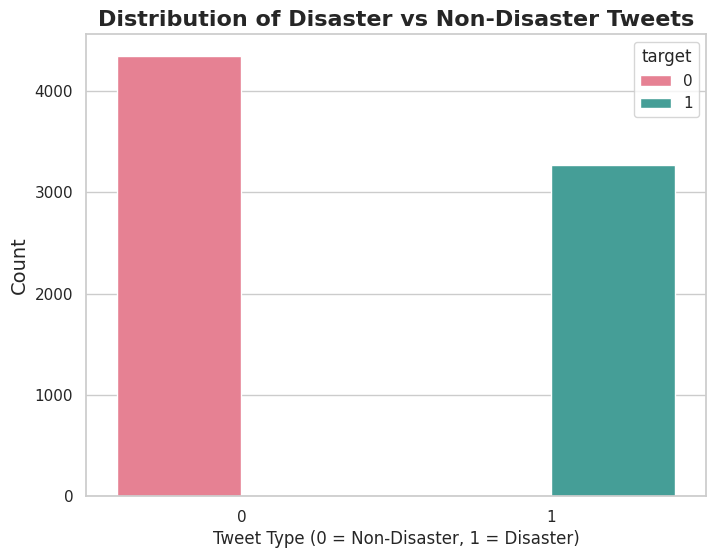

In [14]:
# Set plot style
sb.set(style='whitegrid')

# Plot label distribution
plt.figure(figsize=(8, 6))
ax = sb.countplot(x='target', data=train_data, palette='husl', hue='target')

# Customize the title and labels
plt.title('Distribution of Disaster vs Non-Disaster Tweets', fontsize=16, fontweight='bold')
plt.xlabel('Tweet Type (0 = Non-Disaster, 1 = Disaster)', fontsize=12)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

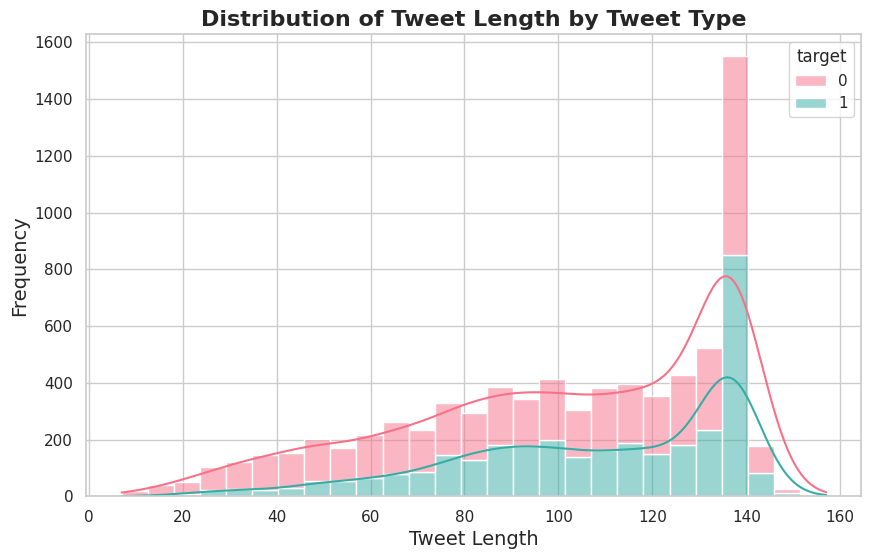

In [15]:
# Copy the dataframe to avoid changing the original one
train_data_copy = train_data.copy()

# Calculate the length of each tweets
train_data_copy['Tweet_length'] = train_data_copy['text'].str.len()

# Set plot style
sb.set(style='whitegrid')

# Create a figure and plot the distribution of tweet lengths
plt.figure(figsize=(10, 6))

# Plot the distribution of tweet lengths for 0 and 1
sb.histplot(data=train_data_copy, x='Tweet_length', hue='target', multiple='stack', palette='husl', kde=True)

# Customize the title and label
plt.xlabel('Tweet Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Tweet Length by Tweet Type', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

In [16]:
X = train_data['text']
Y = train_data['target']

In [17]:
X

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [18]:
Y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [19]:
from tensorflow.keras.utils import to_categorical
y=to_categorical(Y)
num_classes=y.shape[1]
num_classes 

2

In [20]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [22]:
# Load pre-trained BERT tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
number_tokens_sentences = []

# Iterate through each sentence in X
for sent in X:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    number_tokens_sentences.append(len(input_ids))

# Calculate the average sentence length
avg_sentence_length = sum(number_tokens_sentences) / len(number_tokens_sentences)

print('Average sentence length: ', avg_sentence_length)

Average sentence length:  33.10876132930514


In [24]:
def transformation(X):
    # set array dimensions
    seq_len = 45

    # We create the Xids empty list for input_ids and the Xmask empty list for attention_masks.
    Xids =[]
    Xmask=[]
    
    for sentence in X: # We pull all comments from the corpus in order.
        
        tokens = tokenizer.encode_plus(sentence, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True) 
        # We convert each comment we capture into vectors.
        # assign tokenized outputs to respective rows in numpy arrays
        Xids.append(tokens['input_ids']) 
        Xmask.append(tokens['attention_mask']) 

    return np.array(Xids), np.array(Xmask) # We are converting Xids

In [25]:
Xids_train, Xmask_train = transformation(X_train)
Xids_val, Xmask_val = transformation(X_val)

In [26]:
print("Xids_train.shape  :", Xids_train.shape)
print("Xmask_train.shape :", Xmask_train.shape)
print("Xids_val.shape   :", Xids_val.shape)
print("Xmask_val.shape  :", Xmask_val.shape)

Xids_train.shape  : (6851, 45)
Xmask_train.shape : (6851, 45)
Xids_val.shape   : (762, 45)
Xmask_val.shape  : (762, 45)


<h3>Xids and Xmask are necessary inputs for transformer models like BERT, ensuring that the input data is tokenized uniformly and the model can distinguish between real tokens and padding.</h3>


In [27]:
import tensorflow as tf
dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, y_train))
dataset_train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(45,), dtype=tf.int64, name=None), TensorSpec(shape=(45,), dtype=tf.int64, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [28]:
dataset_val = tf.data.Dataset.from_tensor_slices((Xids_val, Xmask_val, y_val))
dataset_val

<_TensorSliceDataset element_spec=(TensorSpec(shape=(45,), dtype=tf.int64, name=None), TensorSpec(shape=(45,), dtype=tf.int64, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [29]:
def map_func(Xids, Xmask, labels):
    print(labels)
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Xids, 'attention_mask': Xmask},labels

In [30]:
final_dataset_train = dataset_train.map(map_func)
final_dataset_val = dataset_val.map(map_func) 

Tensor("args_2:0", shape=(2,), dtype=float64)
Tensor("args_2:0", shape=(2,), dtype=float64)


In [31]:
# fit into a batch of 32
batch_size = 32
train_ds = final_dataset_train.batch(batch_size)
val_ds = final_dataset_val.batch(batch_size)

In [32]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from transformers import TFBertModel

# Define a custom layer to integrate the BERT model
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs["pooler_output"]  # Extract the pooled output

def create_model():
    # Define input layers
    input_ids = Input(shape=(45,), name='input_ids', dtype=tf.int32)
    attention_mask = Input(shape=(45,), name='attention_mask', dtype=tf.int32)
    
    # Pass inputs to the custom BertLayer
    bert_output = BertLayer()([input_ids, attention_mask])
    
    # Add custom layers on top of the BERT output
    x = Dense(45, activation='relu')(bert_output)
    x = BatchNormalization()(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Define the complete model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create and compile the model
model_obj = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
loss = CategoricalCrossentropy()
recall = Recall()

model_obj.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', recall])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [33]:
model_obj.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer          │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 45)        │     34,605 │ bert_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 45)        │        180 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         92 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,877 (136.24 KB)

 Trainable params: 34,787 (135.89 KB)

 Non-trainable params: 90 (360.00 B)

In [36]:
model_obj.fit(train_ds, validation_data= val_ds, epochs=10)

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 606s 3s/step - accuracy: 0.7586 - loss: 0.5073 - recall: 0.7586 - val_accuracy: 0.6168 - val_loss: 0.7330 - val_recall: 0.6168
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.7672 - loss: 0.4951 - recall: 0.7672 - val_accuracy: 0.6115 - val_loss: 0.7580 - val_recall: 0.6115
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 606s 3s/step - accuracy: 0.7727 - loss: 0.4857 - recall: 0.7727 - val_accuracy: 0.6220 - val_loss: 0.7340 - val_recall: 0.6220
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.7799 - loss: 0.4783 - recall: 0.7799 - val_accuracy: 0.6260 - val_loss: 0.7355 - val_recall: 0.6260
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 622s 3s/step - accuracy: 0.7799 - loss: 0.4731 - recall: 0.7799 - val_accuracy: 0.6824 - val_loss: 0.6462 - val_recall: 0.6824
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.7837 - loss: 0.4686 - recall: 0.7837 - val_accuracy: 0.6483 - val_loss: 0.7046 - val_recall: 0.648

In [35]:
model_obj.history.history

{'accuracy': [0.6726025342941284, 0.7341994047164917, 0.7534666657447815],
 'loss': [0.618563711643219, 0.5462052822113037, 0.5186125040054321],
 'recall': [0.6726025342941284, 0.7341994047164917, 0.7534666657447815],
 'val_accuracy': [0.6154855489730835, 0.6338582634925842, 0.5839895009994507],
 'val_loss': [0.6521779894828796, 0.6657184958457947, 0.7971555590629578],
 'val_recall': [0.6154855489730835, 0.6338582634925842, 0.5839895009994507]}